In [1]:
import os
import sys
import warnings
import numpy as np
from pathlib import Path
import pickle
from tqdm import tqdm
import matplotlib.pyplot as plt
#from sklearn.manifold import TSNE


import numpy as np
import scipy.integrate
import sympy as sp
import pickle
from pathlib import Path
import matplotlib.pyplot as plt

sys.path.append("../sae/")
sys.path.append("../odeformer/")
sys.path.append("../odeformer/odeformer")
sys.path.append("../odeformer/odeformer/model")
sys.path.append("../odeformer/odeformer/envs")


import sys
import os
import gzip
import pickle
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from tqdm import tqdm

from utils import *
from analysis_utils import *

from sae import SparseAutoencoder

%env CUDA_VISIBLE_DEVICES=0

import enum
import strenum
import sys
from typing import Callable, TypeAlias
import torch
import torch.nn as nn
import torch.nn.functional as F
from mishax import ast_patcher
from mishax import safe_greenlet
import numpy as np
import matplotlib.pyplot as plt
import odeformer

import scipy.integrate
import sympy as sp
import pickle
from pathlib import Path
import matplotlib.pyplot as plt

from tqdm import tqdm
import matplotlib.pyplot as plt

from odeformer.model import SymbolicTransformerRegressor
from transformer import MultiHeadAttention, TransformerFFN

from odeformer.metrics import r2_score

from IPython.utils import io
import time
from joblib import Parallel, delayed

env: CUDA_VISIBLE_DEVICES=0


In [2]:
run_dir = '../sae/sae.encoder.outer.residual1_20250308_230626'
model_path = f'{run_dir}/checkpoints/sae_best_encoder.outer.residual1.pt'
output_dir = f"{run_dir}/feature_activations"
device = "cpu"
print(f"Using device: {device}")

print(f"Attempting to load model from: {model_path}")
sae_model = SparseAutoencoder(input_dim=256, latent_dim=1280)
sae_model.load_state_dict(torch.load(model_path, map_location=device,weights_only=True))
sae_model.eval()

print("Model loaded successfully")
print(f"Model name: {sae_model.name}")
print(f"Model input dimension: {sae_model.input_dim}")
print(f"Model latent dimension: {sae_model.latent_dim}")

Using device: cpu
Attempting to load model from: ../sae/sae.encoder.outer.residual1_20250308_230626/checkpoints/sae_best_encoder.outer.residual1.pt
Model loaded successfully
Model name: None
Model input dimension: 256
Model latent dimension: 1280


In [3]:
data_path = '../data/activations/random_solutions_activations_10k.pkl.gz'
print(f"Attempting to load data from: {data_path}")
with gzip.open(data_path, 'rb') as file:
    collected_act = pickle.loads(file.read())
print(f"Data loaded successfully. Found {len(collected_act)} samples.")

Attempting to load data from: ../data/activations/random_solutions_activations_10k.pkl.gz
Data loaded successfully. Found 9998 samples.


In [4]:
collected_act[0][1]['residual_stream']['encoder.outer.residual0'].keys()

dict_keys([(1, 195, 256)])

In [5]:
output_dir = '../data/activations/'
layer_name = 'encoder.outer.residual1'

In [6]:
samples = extract_activations_and_trajectories(sae_model, collected_act, layer_name=layer_name)

Extracting activations: 9998it [00:14, 674.09it/s]

Extracted data from 9998 trajectories


In [14]:
subset_latent_vectors_lst=[]
for i in range(len(samples)):
    for j in range(len(samples[i]['activations'])):
        subset_latent_vectors_lst.append(samples[i]['activations'][j])

In [15]:
subset_latent_vectors_np=np.array(subset_latent_vectors_lst)

In [16]:
subset_latent_vectors = subset_latent_vectors_np[np.random.randint(subset_latent_vectors_np.shape[0], size=200000), :]

In [22]:
from cuml.manifold import TSNE
# Configure t-SNE
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.colors import LinearSegmentedColormap
import os
from cuml.manifold import TSNE
import seaborn as sns

# Configure t-SNE
tsne = TSNE(
    n_components=2,
    perplexity=30,
    n_iter=1000,
    learning_rate=200,
    random_state=42
)

# Apply t-SNE
tsne_results = tsne.fit_transform(subset_latent_vectors)
print(f"t-SNE completed. Output shape: {tsne_results.shape}")

[2025-04-04 23:41:19.317] [CUML] [warning] # of Nearest Neighbors should be at least 3 * perplexity. Your results might be a bit strange...
t-SNE completed. Output shape: (200000, 2)


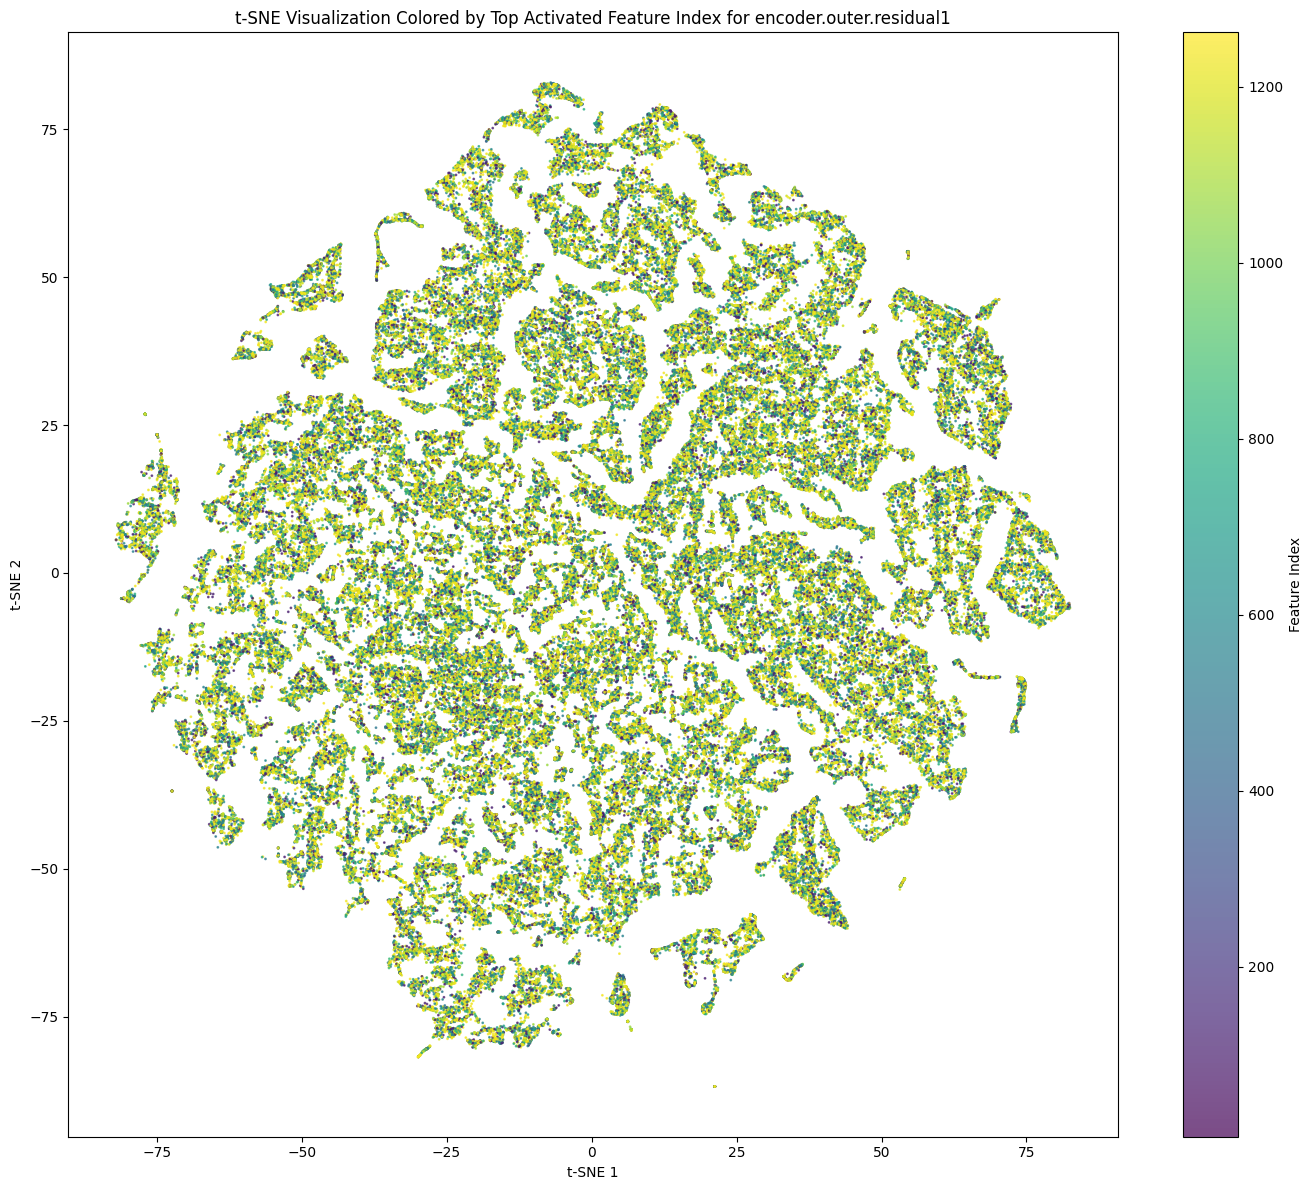

In [26]:
# 1. Visualization colored by top feature index
plt.figure(figsize=(14, 12))
scatter = plt.scatter(
    tsne_results[:, 0], 
    tsne_results[:, 1], 
    c=top_feature_indices[:subset_latent_vectors.shape[0]], 
    #cmap='tab20', 
    alpha=0.7, 
    s=1
)
plt.colorbar(scatter, label='Feature Index')
plt.title(f't-SNE Visualization Colored by Top Activated Feature Index for {layer_name}')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.tight_layout()
plt.show()

In [9]:
# Save t-SNE results
tsne_results_path = os.path.join(output_dir, 'tsne_results.npy')
np.save(tsne_results_path, tsne_results)
print(f"Saved t-SNE results to {tsne_results_path}")

# Create a directory for feature-specific visualizations
feature_viz_dir = os.path.join(output_dir, 'feature_visualizations')
os.makedirs(feature_viz_dir, exist_ok=True)

# Identify top activated features for each data point
def get_top_k_features(latent_vectors, k=1):
    """Get the indices of the top k activated features for each data point"""
    # Get the top k feature indices
    top_k_indices = np.argsort(latent_vectors, axis=1)[:, -k:]
    # Get the top k feature values
    top_k_values = np.take_along_axis(latent_vectors, top_k_indices, axis=1)
    return top_k_indices, top_k_values

# Get the top activated feature for each data point
top_feature_indices, top_feature_values = get_top_k_features(subset_latent_vectors, k=1)
top_feature_indices = top_feature_indices.flatten()
top_feature_values = top_feature_values.flatten()

# 1. Visualization colored by top feature index
plt.figure(figsize=(14, 12))
scatter = plt.scatter(
    tsne_results[:, 0], 
    tsne_results[:, 1], 
    c=top_feature_indices, 
    cmap='tab20', 
    alpha=0.7, 
    s=15
)
plt.colorbar(scatter, label='Feature Index')
plt.title(f't-SNE Visualization Colored by Top Activated Feature Index for {layer_name}')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.tight_layout()

# Save the plot
feature_index_path = os.path.join(output_dir, 'tsne_by_feature_index.png')
plt.savefig(feature_index_path, dpi=300)
plt.close()
print(f"Saved feature index visualization to {feature_index_path}")

# 2. Visualization colored by activation level
plt.figure(figsize=(14, 12))
scatter = plt.scatter(
    tsne_results[:, 0], 
    tsne_results[:, 1], 
    c=top_feature_values, 
    cmap='viridis', 
    alpha=0.7, 
    s=15
)
plt.colorbar(scatter, label='Activation Level')
plt.title(f't-SNE Visualization Colored by Top Feature Activation Level for {layer_name}')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.tight_layout()

# Save the plot
activation_level_path = os.path.join(output_dir, 'tsne_by_activation_level.png')
plt.savefig(activation_level_path, dpi=300)
plt.close()
print(f"Saved activation level visualization to {activation_level_path}")

# 3. Create visualizations for top N most activated features
N = 10  # Number of top features to visualize
feature_activation_sum = np.sum(subset_latent_vectors > 0, axis=0)
top_features = np.argsort(feature_activation_sum)[-N:][::-1]

print(f"Visualizing top {N} most frequently activated features")
for i, feature_idx in enumerate(top_features):
    # Create a boolean mask for points where this feature is the top activated
    mask = top_feature_indices == feature_idx
    if np.sum(mask) == 0:
        print(f"Feature {feature_idx} is not the top feature for any data point - skipping")
        continue
    
    plt.figure(figsize=(12, 10))
    # Plot all points in light grey
    plt.scatter(tsne_results[:, 0], tsne_results[:, 1], color='lightgrey', alpha=0.3, s=10)
    # Highlight points where this feature is the top activated
    plt.scatter(
        tsne_results[mask, 0], 
        tsne_results[mask, 1], 
        color='red', 
        alpha=0.8, 
        s=20
    )
    plt.title(f'Data points with Feature {feature_idx} as top activated')
    plt.xlabel('t-SNE 1')
    plt.ylabel('t-SNE 2')
    plt.tight_layout()
    
    # Save the plot
    feature_path = os.path.join(feature_viz_dir, f'feature_{feature_idx}.png')
    plt.savefig(feature_path, dpi=300)
    plt.close()
    print(f"Saved visualization for feature {feature_idx}")

# 4. Create a heatmap showing feature co-activation patterns
print("Creating feature co-activation heatmap...")
# Count how many times each feature is activated
activated_vectors = (subset_latent_vectors > 0).astype(int)
feature_counts = np.sum(activated_vectors, axis=0)

# Get the top M most frequently activated features
M = min(50, subset_latent_vectors.shape[1])  # Cap at 50 features or total features, whichever is smaller
top_M_features = np.argsort(feature_counts)[-M:][::-1]

# Calculate co-activation matrix for top features
coactivation_matrix = np.zeros((M, M))
for i, f1 in enumerate(top_M_features):
    for j, f2 in enumerate(top_M_features):
        # Count how many samples have both features activated
        coactivation = np.sum((activated_vectors[:, f1] > 0) & (activated_vectors[:, f2] > 0))
        # Normalize by the minimum of the individual activation counts
        normalization = min(feature_counts[f1], feature_counts[f2])
        if normalization > 0:
            coactivation_matrix[i, j] = coactivation / normalization
        else:
            coactivation_matrix[i, j] = 0

# Plot the co-activation heatmap
plt.figure(figsize=(14, 12))
sns.heatmap(
    coactivation_matrix,
    cmap='YlOrRd',
    xticklabels=top_M_features,
    yticklabels=top_M_features
)
plt.title('Feature Co-activation Matrix (Normalized)')
plt.xlabel('Feature Index')
plt.ylabel('Feature Index')
plt.tight_layout()

# Save the heatmap
heatmap_path = os.path.join(output_dir, 'feature_coactivation_heatmap.png')
plt.savefig(heatmap_path, dpi=300)
plt.close()
print(f"Saved co-activation heatmap to {heatmap_path}")

# Continue with your existing code for sparsity analysis
print("Analyzing latent space...")

# Calculate sparsity
activation_rate = np.mean(latent_vectors > 0, axis=0)
overall_sparsity = np.mean(latent_vectors > 0)
print(f"Average activation rate: {overall_sparsity:.4f}")

# Create a histogram of the activation rates
plt.figure(figsize=(12, 6))
plt.hist(activation_rate, bins=50)
plt.title('Histogram of Feature Activation Rates')
plt.xlabel('Activation Rate')
plt.ylabel('Count')
plt.axvline(overall_sparsity, color='r', linestyle='--', 
           label=f'Average Activation Rate: {overall_sparsity:.4f}')
plt.legend()
plt.tight_layout()

# Save the histogram
histogram_path = os.path.join(output_dir, 'activation_rate_histogram.png')
plt.savefig(histogram_path, dpi=300)
plt.close()
print(f"Saved activation rate histogram to {histogram_path}")

# Create scatter plot comparing feature activation vs feature magnitude
feature_magnitudes = np.mean(np.abs(latent_vectors[latent_vectors > 0]), axis=0)
plt.figure(figsize=(10, 8))
plt.scatter(activation_rate, feature_magnitudes, alpha=0.5)
plt.title('Feature Activation Rate vs. Feature Magnitude')
plt.xlabel('Activation Rate')
plt.ylabel('Average Magnitude When Active')
plt.tight_layout()

# Save the scatter plot
scatter_path = os.path.join(output_dir, 'activation_vs_magnitude.png')
plt.savefig(scatter_path, dpi=300)
plt.close()
print(f"Saved feature activation vs magnitude plot to {scatter_path}")

print("Analysis complete!")

[2025-04-04 01:34:03.986] [CUML] [warning] # of Nearest Neighbors should be at least 3 * perplexity. Your results might be a bit strange...
t-SNE completed. Output shape: (1221206, 2)
Saved t-SNE results to ../data/activations/tsne_results.npy
Saved feature index visualization to ../data/activations/tsne_by_feature_index.png
Saved activation level visualization to ../data/activations/tsne_by_activation_level.png
Visualizing top 10 most frequently activated features
Saved visualization for feature 1234
Saved visualization for feature 766
Saved visualization for feature 1103
Saved visualization for feature 605
Saved visualization for feature 898
Saved visualization for feature 745
Feature 292 is not the top feature for any data point - skipping
Feature 1185 is not the top feature for any data point - skipping
Saved visualization for feature 1007
Saved visualization for feature 1173
Creating feature co-activation heatmap...
Saved co-activation heatmap to ../data/activations/feature_coacti

NameError: name 'latent_vectors' is not defined